In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.optimize as spo
import scipy.signal as sps
from pathlib import Path

from spectrometer import FID1D, plot

In [41]:
# Load raw *.fid data
file = Path("../data/20230719-160040-Water_1H_andrew_probe_9us_pulse_25us_delay.fid")
fid = FID1D.from_file(file)

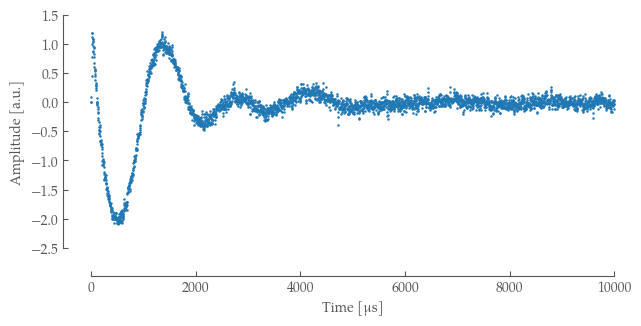

In [42]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [μs]")

plot.format_for_thesis(axes)

fig.savefig("fid_raw.pdf")

In [43]:
# Define fitting function
def fit_decay(x: npt.NDArray, y: npt.NDArray) -> dict:
    """Fit a decay exponential to the input sequence

    f(x) = amplitude * e^(-lambda*t) + offset

    Returns:
        Fitting parameters "amplitude", "lambda", "offset" and the resulting "function"
    """
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    def decay(t, amplitude, lambda_, offset):
        return amplitude * np.exp(-lambda_ * t) + offset

    # Guess initial fitting parameters
    guess_amplitude = np.max(y) - np.min(y)
    guess_offset = np.min(y)
    guess_lambda = 0
    guess = (guess_amplitude, guess_lambda, guess_offset)

    popt, _pcov = spo.curve_fit(decay, x, y, p0=guess)
    return {
        "amplitude": popt[0],
        "lambda": popt[1],
        "offset": popt[2],
        "function": lambda t: decay(t, *popt),
    }

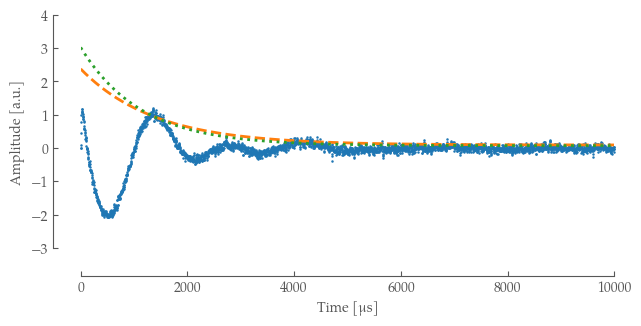

In [44]:
# Try to plot simple least squares fit
# Try fitting the envelope
envelope = np.abs(sps.hilbert(fid.data.real))
fit_env = fit_decay(fid.us_scale, envelope)
us_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    us_scale_fine,
    fit_env["function"](us_scale_fine),
    linestyle="--",
    linewidth=2,
)

# Try fitting the absolute directly
fit_abs = fit_decay(fid.us_scale, np.abs(fid.data))
axes.plot(
    us_scale_fine,
    fit_abs["function"](us_scale_fine),
    linestyle=":",
    linewidth=2,
)

fig.savefig("fid_fit.pdf")
fig

/home/max/Projects/nmr-spectrometer/software/spectrometer/.venv/lib64/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


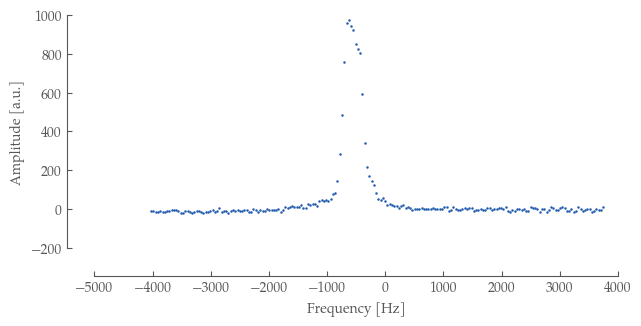

In [45]:
# Fourier Transform
hz_scale, fft_vals = fid.simple_fft(phase_shift_kwargs={"p0": 68, "p1": 0})

# Plot Fourier Transform
cm = 1 / 2.54
fig, axes = plt.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    layout="constrained",
)
axes.plot(
    hz_scale[4000:4200],
    fft_vals[4000:4200],
    color=eth_colors[0],
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_for_thesis(axes)

fig.savefig("fid_raw.pdf")

In [46]:
# TODO: Fourier Transform & Lorentz fit


# Define fitting function
def fit_lorentz(x: npt.NDArray, y: npt.NDArray) -> dict:
    """Fit a lorentzian function to the input sequence

    f(x) = amplitude * (gamma**2 / ((x - x0)**2 + gamma**2))

    Returns:
        Fitting parameters "amplitude", "lambda", "offset" and the resulting "function"
    """
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    def lorentzian(x, position, gamma, amplitude):
        return amplitude * (
            np.power(x, 2) / (np.power((x - position), 2) + np.power(gamma, 2))
        )

    # Guess initial fitting parameters
    guess_amplitude = np.max(y) - np.min(y)
    guess_offset = np.min(y)
    guess_lambda = 0
    guess = (guess_amplitude, guess_lambda, guess_offset)

    popt, _pcov = spo.curve_fit(lorentzian, x, y, p0=guess)
    return {
        "amplitude": popt[0],
        "lambda": popt[1],
        "offset": popt[2],
        "function": lambda t: lorentzian(t, *popt),
    }

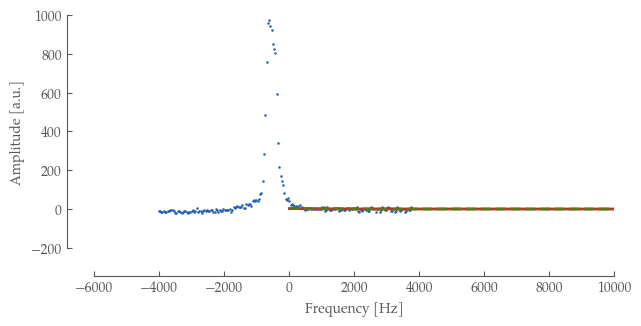

In [47]:
# Try to plot simple least squares fit for a lorentzian peak
envelope = np.abs(sps.hilbert(fid.data.real))
fit_env = fit_decay(fid.us_scale, envelope)
us_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    us_scale_fine,
    fit_env["function"](us_scale_fine),
    linestyle="-",
    color=eth_colors[1],
    linewidth=2,
)

# Try fitting the absolute directly
fit_abs = fit_decay(fid.us_scale, np.abs(fid.data))
axes.plot(
    us_scale_fine,
    fit_abs["function"](us_scale_fine),
    linestyle="--",
    color=eth_colors[2],
    linewidth=2,
)

fig.savefig("fid_fit.pdf")
fig